In [1]:
import os
import torch
import gym, matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn as nn
from torch.optim import AdamW

from parallel_env import ParallelEnv, ParallelWrapper 


# Create and processs the environment

In [2]:
env = gym.make('CartPole-v1')
dims = env.observation_space.shape[0]
actions = env.action_space.n

/home/ajit.kumar@SNU.IN/anaconda3/envs/udemy-rl/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


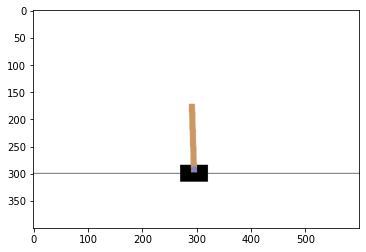

In [3]:
env.reset()
plt.imshow(env.render(mode='rgb_array'))
env.close()

In [4]:
num_envs = 8 #os.cpu_count() max is 16 on these workstations

In [5]:
def create_env(env_name, seed):
    env = gym.make(env_name)
    return env

In [6]:
env_fns = [lambda: create_env('CartPole-v1',rank) for rank in range(num_envs)]


parallel_env = ParallelEnv(env_fns)

/home/ajit.kumar@SNU.IN/anaconda3/envs/udemy-rl/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(
/home/ajit.kumar@SNU.IN/anaconda3/envs/udemy-rl/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(
/home/ajit.kumar@SNU.IN/anaconda3/envs/udemy-rl/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(
/home/ajit.kumar@SNU.IN/anaconda3/envs/udemy-rl/lib/python3.10/site-packages/gym/utils/passive

In [7]:
parallel_env.reset()

array([[ 0.04030359,  0.04341412, -0.01913494,  0.02273265],
       [ 0.04454089, -0.04502525, -0.04110698,  0.01759117],
       [ 0.03328272,  0.04610067, -0.04085183,  0.00924329],
       [-0.04661807,  0.00796873,  0.02546181, -0.04535644],
       [-0.00054227,  0.03666577, -0.02581694, -0.0026585 ],
       [-0.00477613, -0.03968655,  0.00917695, -0.03081775],
       [ 0.04794167,  0.0345131 , -0.03162109, -0.03956192],
       [-0.02910187,  0.04129063,  0.01899459, -0.00854895]],
      dtype=float32)

In [8]:
class PreprocessEnv(ParallelWrapper):
    def __init__(self, parallel_env):
        ParallelWrapper.__init__(self, parallel_env)
    
    # reset 
    def reset(self):
        state = self.venv.reset()
        return torch.from_numpy(state).float()
        
    # step_async
    def step_async(self, actions):
        actions = actions.squeeze().numpy()
        self.venv.step_async(actions)
        
    # step_wait
    def step_wait(self):
        next_state, reward, done, info = self.venv.step_wait()
        next_state = torch.from_numpy(next_state).float()
        reward = torch.tensor(reward).unsqueeze(1).float()
        done = torch.tensor(done).unsqueeze(1)
        return next_state, reward, done, info

In [9]:
parallel_env = PreprocessEnv(parallel_env)

In [10]:
state = parallel_env.reset()

_, reward, done, _ = parallel_env.step(torch.zeros(num_envs,1,dtype=torch.int32))

In [12]:
done

tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False]])

In [53]:
policy = nn.Sequential(
    nn.Linear(dims, 128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,actions),
    nn.Softmax(dim=-1)
)

In [54]:
neutral_state = torch.zeros(4)
left_danger = torch.tensor([ -2.3, 0., 0., 0.])
right_danger = torch.tensor([ 2.3, 0., 0., 0.])

In [55]:
probs = policy(neutral_state).detach().numpy()

In [56]:
probs

array([0.4465813 , 0.55341864], dtype=float32)

<BarContainer object of 2 artists>

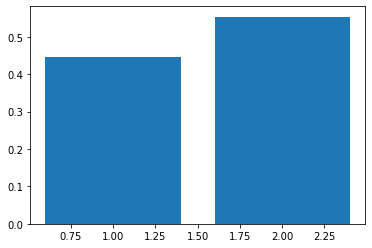

In [64]:
plt.bar([1,2],probs,label= ['left','right'])



In [75]:
def reinforce(policy, episodes, alpha = 1e-4, gamma = 0.99):
    
    optim = AdamW(policy.parameters(), lr = alpha)
    stats = { 'Loss': [], 'Returns':[] }

    for episode in tqdm(range(1,episodes+1)):
        state = parallel_env.reset()
        done_b = torch.zeros((num_envs,1), dtype=torch.bool)
        transitions = []
        ep_return = torch.zeros((num_envs,1))
        
        while not done_b.all():
            action = policy(state).multinomial(1).detach()
            next_state, reward, done, _ = parallel_env.step(action)
            transitions.append([state, action, ~done_b*reward])
            ep_return += reward
            done_b |= done
            state = next_state
        G = torch.zeros((num_envs,1))
        for t, (state_t, action_t, reward_t) in reversed(list(enumerate(transitions))):
            G = reward_t * gamma*G
            probs_t = policy(state_t)
            log_probs_t = torch.log(probs_t + 1e-6)
            action_log_prob_t = log_probs_t.gather(1, action_t)
            entropy_t = -torch.sum(probs_t * log_probs_t, dim = -1, keepdim = True)
            gamma_t = gamma**t
            pg_loss_t = -gamma_t*action_log_prob_t*G
            total_loss_t = (pg_loss_t - 0.01*entropy_t).mean()
            
            policy.zero_grad()
            total_loss_t.backward()
            optim.step()
        stats['Loss'].append(total_loss_t.item())
        stats['Returns'].append(ep_return.mean().item())
    return stats

In [76]:
parallel_env.reset()

stats = reinforce(policy, 200, alpha = 1e-4, gamma = 0.99)

100%|█████████████████████████████████████████| 200/200 [00:13<00:00, 14.87it/s]


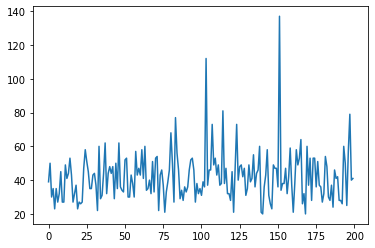

In [80]:
plt.plot(stats['Returns'])

<BarContainer object of 2 artists>

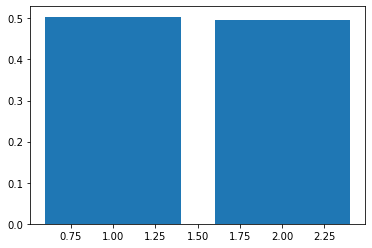

In [84]:
neutral_state = torch.zeros(4)
left_danger = torch.tensor([ -2.31, 0., 0., 0.])
right_danger = torch.tensor([ 2.3, 0., 0., 0.])
probs = policy(right_danger).detach().numpy()
plt.bar([1,2],probs)